In [1]:
import os
import sys
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..')) # Adjust as needed
if project_root not in sys.path:
    sys.path.append(project_root) # add notebook to sys.path

In [2]:
import re

import torch
import torch.nn.functional as F

# 1: Downloading the dataset

In [3]:
from utils.data import download_mtfraeng

In [4]:
raw_text = download_mtfraeng()

In [5]:
print(raw_text[0:300])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez !
Go on.	Poursuis.
Go on.	Continuez.
Go on.	Poursuivez.
Hello!	Bonjour !
Hello!	Salut !
I see.	Je c


In [6]:
print(raw_text[-9949:])

He and I have a near-telepathic understanding of each other. No sooner does one of us say something than the other is already responding.	Lui et moi avons une compréhension quasi-télépathique de chacun. Aussitôt que l'un de nous dit quelque chose, l'autre est déjà en train de répondre.
Although rainforests make up only two percent of the earth's surface, over half the world's wild plant, animal and insect species live there.	Bien que les forêts tropicales ne couvrent que 2% de la surface de la terre, plus de la moitié des espèces animales, végétales et des insectes y vivent.
She has a boyfriend she's been going out with since high school, but she feels their relationship has stagnated, so she's become dissatisfied.	Elle a un copain avec qui elle sort depuis le lycée, mais elle a le sentiment que leur relation stagne, alors elle est mécontente.
If you translate from your second language into your own native language, rather than the other way around, you're less likely to make mistakes.

In [7]:
for c in raw_text[10000:30000]:
    if re.match('[^a-zA-z .!\n\t-ÇûéÉ?\']', c):
        if c == '\xa0':
            print(c)
        #print(repr(c).strip('\''), end=' ')

In [8]:
from utils.data import preprocess_mt

In [9]:
text = preprocess_mt(raw_text)

for c in text[0:1000]:
    print(repr(c).strip('\''), end='')

go .\tva !\nhi .\tsalut !\nrun !\tcours !\nrun !\tcourez !\nwho ?\tqui ?\nwow !\tça alors !\nfire !\tau feu !\nhelp !\tà l"'"aide !\njump .\tsaute .\nstop !\tça suffit !\nstop !\tstop !\nstop !\tarrête-toi !\nwait !\tattends !\nwait !\tattendez !\ngo on .\tpoursuis .\ngo on .\tcontinuez .\ngo on .\tpoursuivez .\nhello !\tbonjour !\nhello !\tsalut !\ni see .\tje comprends .\ni try .\tj"'"essaye .\ni won !\tj"'"ai gagné !\ni won !\tje l"'"ai emporté !\ni won .\tj’ai gagné .\noh no !\toh non !\nattack !\tattaque !\nattack !\tattaquez !\ncheers !\tsanté !\ncheers !\tà votre santé !\ncheers !\tmerci !\ncheers !\ttchin-tchin !\nget up .\tlève-toi .\ngo now .\tva , maintenant .\ngo now .\tallez-y maintenant .\ngo now .\tvas-y maintenant .\ngot it !\tj"'"ai pigé !\ngot it !\tcompris !\ngot it ?\tpigé ?\ngot it ?\tcompris ?\ngot it ?\tt"'"as capté ?\nhop in .\tmonte .\nhop in .\tmontez .\nhug me .\tserre-moi dans tes bras !\nhug me .\tserrez-moi dans vos bras !\ni fell .\tje suis tombée .\ni fe

In [10]:
from utils.data import tokenize_mt

In [11]:
src, tgt = tokenize_mt(text)
print(len(src))

167130


In [12]:
from utils.data import build_arrays_mt, build_mt

In [13]:
build_arrays_mt(raw_text, num_train=2, num_val=1)

((tensor([[3, 0, 1, 2, 2, 2, 2, 2, 2],
          [3, 0, 1, 2, 2, 2, 2, 2, 2],
          [3, 3, 1, 2, 2, 2, 2, 2, 2]]),
  tensor([[1, 4, 0, 2, 3, 3, 3, 3, 3],
          [1, 4, 0, 2, 3, 3, 3, 3, 3],
          [1, 4, 0, 2, 3, 3, 3, 3, 3]]),
  tensor([3, 3, 3]),
  tensor([[4, 0, 2, 3, 3, 3, 3, 3, 3],
          [4, 0, 2, 3, 3, 3, 3, 3, 3],
          [4, 0, 2, 3, 3, 3, 3, 3, 3]])),
 <utils.vocab.Vocab at 0x11f7c5a60>)

In [14]:
_, src_vocab, tgt_vocab = build_arrays_mt(download_mtfraeng())
src, tgt, _,  _ = build_mt(['hi .'], ['salut .'], src_vocab, tgt_vocab)
print('source:', src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [15]:
from utils.data import get_data_mt

In [16]:
train_dl, val_dl, src_vocab, tgt_vocab = get_data_mt()

In [17]:
for src, tgt, src_valid_lens, tgt_label in train_dl:
    print(src.shape, tgt.shape, src_valid_lens.shape) 
    print(tgt_label.shape)
    break

torch.Size([4, 10]) torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10])


# 2. Encoder-Decoder

In [18]:
from utils.models import EncoderDecoder

# 3: Sequence-to-Sequence

In [19]:
from utils.models import Seq2SeqEncoder, Seq2SeqDecoder, Seq2Seq

In [20]:
def loss_fn_mt(model, Y_hat, Y):
    """Compute masked loss, padded values set to zero"""
    Y_hat = Y_hat.reshape(-1, Y_hat.shape[-1])
    Y = Y.reshape(-1,)
    l = F.cross_entropy(Y_hat, Y, reduction='none')
    mask = (Y != model.tgt_pad_idx).type(torch.float32)
    return (l * mask).sum() / mask.sum()

# 4. Train Model

In [21]:
from utils.train import fit_mt

### 4.1: Small Experiment

In [22]:
batch_size = 4
num_steps = 10
num_train = 1024
num_val = 512
embed_size = 8
num_layers = 2
hidden_size = 16
dropout = 0.2
num_epochs = 10
lr = 0.005

In [23]:
train_dl, val_dl, src_vocab, tgt_vocab = get_data_mt(
                        batch_size, num_steps, num_train, num_val)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, 
                         hidden_size, num_layers, dropout=dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, 
                         hidden_size, num_layers, dropout=dropout)
model = Seq2Seq(encoder, decoder, tgt_vocab['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = lambda Y_hat, Y: loss_fn_mt(model, Y_hat, Y)

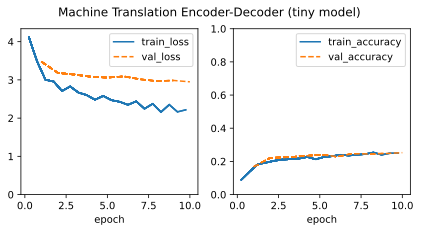

In [24]:
model = fit_mt(train_dl, val_dl, model, optimizer, loss_fn, num_epochs, 
       id="Machine Translation Encoder-Decoder (tiny model)")

### 4.2: Larger Experiment

In [25]:
batch_size = 128
num_steps = 10
num_train = 1024
num_val = 512
embed_size = 256
hidden_size = 256
num_layers = 2
dropout = 0.2
num_epochs = 30
lr = 0.005

In [26]:
train_dl, val_dl, src_vocab, tgt_vocab = get_data_mt(batch_size, num_steps, num_train, num_val)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, hidden_size, num_layers, dropout=dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, hidden_size, num_layers, dropout=dropout)
model = Seq2Seq(encoder, decoder, tgt_vocab['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = lambda Y_hat, Y: loss_fn_mt(model, Y_hat, Y)

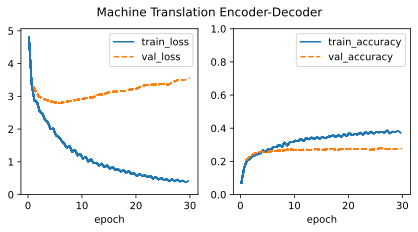

In [27]:
model = fit_mt(train_dl, val_dl, model, optimizer, loss_fn, num_epochs, 
       id="Machine Translation Encoder-Decoder")

### Unroll model predictions

In [28]:
for batch in val_dl:
    outputs, _ = model.predict_step(batch, num_steps)
    print(outputs.shape)
    break

torch.Size([128, 10])


### Make BLEU predictions

In [29]:
from utils.metrics import bleu

In [30]:
sentence = "j\'ai perdu ."
bleu(sentence, sentence, k=2)

1.0

In [31]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
arrays = build_mt(engs, fras, src_vocab, tgt_vocab)
preds, _ = model.predict_step(arrays, num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu: '
        f'{bleu(" ".join(translation), fr, k=2):.3f} '
        f'Target: {fr}')

go . => ['<unk>', '.'], bleu: 0.000 Target: va !
i lost . => ["j'ai", 'perdu', '.'], bleu: 1.000 Target: j'ai perdu .
he's calm . => ['il', 'est', 'ici', '.'], bleu: 0.658 Target: il est calme .
i'm home . => ['je', 'suis', 'ici', '.'], bleu: 0.512 Target: je suis chez moi .
